In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

In [67]:
def get_result_dataframe(dataset_name, model_name, path):
    results = []

    n_folds = len(glob(path + "validation_fold_*.csv"))
    print(n_folds)
    for i in range(n_folds):
        results_val = pd.read_csv(path + f"validation_fold_{i}.csv")

        results_val = results_val.groupby("alpha").apply(lambda x: x.sort_values("score", ascending=False).head(1), include_groups = False).reset_index()
        alpha_list = results_val.alpha.tolist()
        best_models = results_val.model.tolist()

        results_test = pd.read_csv(path + f"test_fold_{i}.csv")
        for alpha, m in zip(alpha_list, best_models):
            best_model = results_test[((results_test.alpha == alpha) & (results_test.model == m))]
            results.append({
                "fold" : i,
                "alpha" : alpha,
                "bal_acc" : best_model.bal_acc.values[0],
                "min_bal_acc" : best_model.min_bal_acc.values[0]
            })

    results = pd.DataFrame(results).groupby("alpha").mean().reset_index()
    return results

10
10
10


/tmp/ipykernel_688/2523885263.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(
/tmp/ipykernel_688/2523885263.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(
/tmp/ipykernel_688/2523885263.py:48: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(


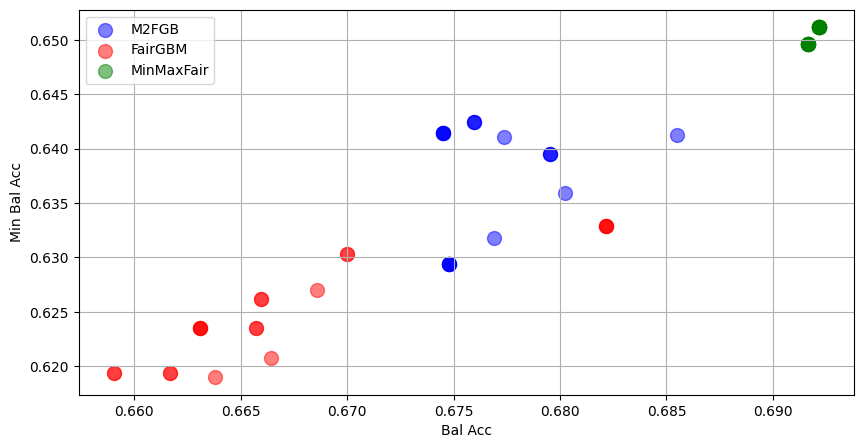

In [69]:
n_groups = 2
dataset_name = "german"


model_name = "M2FGB_grad"
path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
results_m2fgb = get_result_dataframe(dataset_name, model_name, path)

model_name = "FairGBMClassifier"
path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
results_fairgbm = get_result_dataframe(dataset_name, model_name, path)

model_name = "MinMaxFair"
path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
results_mmfair = get_result_dataframe(dataset_name, model_name, path)


fig = plt.subplots(figsize = (10, 5))
#plt.subplot(1, 2, 1)
plt.scatter(
    results_m2fgb.bal_acc,
    results_m2fgb.min_bal_acc,
    c = "blue",
    s = 100,
    vmin = -0.5,
    alpha = 0.5,
    label = "M2FGB"
)

plt.legend()
plt.xlabel("Bal Acc")
plt.ylabel("Min Bal Acc")
plt.grid()

#plt.subplot(1, 2, 2)
plt.scatter(
    results_fairgbm.bal_acc,
    results_fairgbm.min_bal_acc,
    c = "red",
    s = 100,
    vmin = -0.5,
    alpha = 0.5,
    label = "FairGBM",
)


plt.scatter(
    results_mmfair.bal_acc,
    results_mmfair.min_bal_acc,
    c = "green",
    s = 100,
    vmin = -0.5,
    alpha = 0.5,
    label = "MinMaxFair",
)

plt.legend()
plt.xlabel("Bal Acc")
plt.ylabel("Min Bal Acc")
plt.grid(True)
plt.show()


/tmp/ipykernel_688/3781428301.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(
/tmp/ipykernel_688/3781428301.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(
/tmp/ipykernel_688/3781428301.py:48: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(


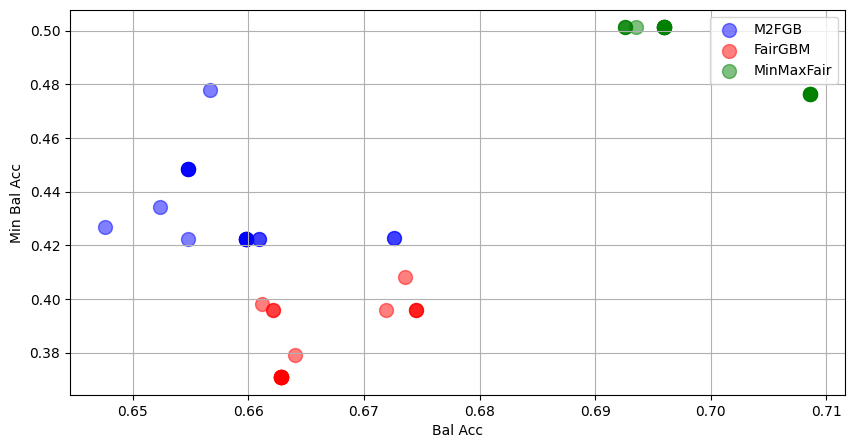

In [59]:
n_groups = 4
dataset_name = "german"



model_name = "M2FGB_grad"
path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
results_m2fgb = get_result_dataframe(dataset_name, model_name, path)

model_name = "FairGBMClassifier"
path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
results_fairgbm = get_result_dataframe(dataset_name, model_name, path)

model_name = "MinMaxFair"
path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
results_mmfair = get_result_dataframe(dataset_name, model_name, path)


fig = plt.subplots(figsize = (10, 5))
#plt.subplot(1, 2, 1)
plt.scatter(
    results_m2fgb.bal_acc,
    results_m2fgb.min_bal_acc,
    c = "blue",
    s = 100,
    vmin = -0.5,
    alpha = 0.5,
    label = "M2FGB"
)

plt.legend()
plt.xlabel("Bal Acc")
plt.ylabel("Min Bal Acc")
plt.grid()

#plt.subplot(1, 2, 2)
plt.scatter(
    results_fairgbm.bal_acc,
    results_fairgbm.min_bal_acc,
    c = "red",
    s = 100,
    vmin = -0.5,
    alpha = 0.5,
    label = "FairGBM",
)


plt.scatter(
    results_mmfair.bal_acc,
    results_mmfair.min_bal_acc,
    c = "green",
    s = 100,
    vmin = -0.5,
    alpha = 0.5,
    label = "MinMaxFair",
)

plt.legend()
plt.xlabel("Bal Acc")
plt.ylabel("Min Bal Acc")
plt.grid(True)
plt.show()


/tmp/ipykernel_688/2711023537.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(
/tmp/ipykernel_688/2711023537.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(
/tmp/ipykernel_688/2711023537.py:48: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(


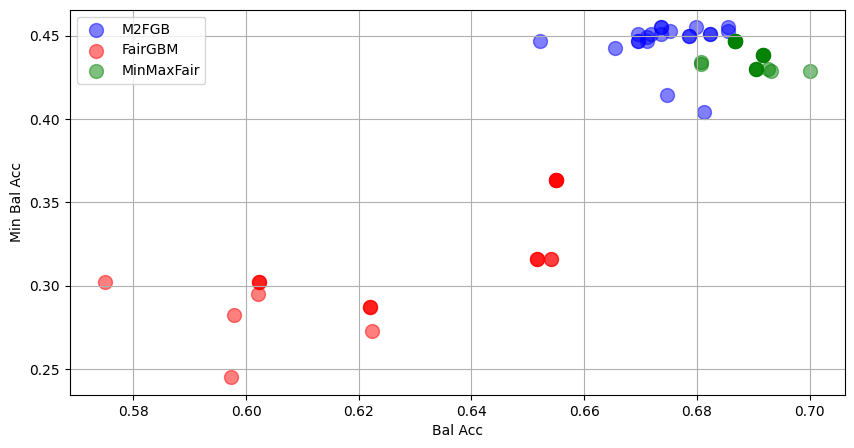

In [58]:
n_groups = 8
dataset_name = "german"



model_name = "M2FGB_grad"
path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
results_m2fgb = get_result_dataframe(dataset_name, model_name, path)

model_name = "FairGBMClassifier"
path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
results_fairgbm = get_result_dataframe(dataset_name, model_name, path)

model_name = "MinMaxFair"
path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
results_mmfair = get_result_dataframe(dataset_name, model_name, path)


fig = plt.subplots(figsize = (10, 5))
#plt.subplot(1, 2, 1)
plt.scatter(
    results_m2fgb.bal_acc,
    results_m2fgb.min_bal_acc,
    c = "blue",
    s = 100,
    vmin = -0.5,
    alpha = 0.5,
    label = "M2FGB"
)

plt.legend()
plt.xlabel("Bal Acc")
plt.ylabel("Min Bal Acc")
plt.grid()

#plt.subplot(1, 2, 2)
plt.scatter(
    results_fairgbm.bal_acc,
    results_fairgbm.min_bal_acc,
    c = "red",
    s = 100,
    vmin = -0.5,
    alpha = 0.5,
    label = "FairGBM",
)


plt.scatter(
    results_mmfair.bal_acc,
    results_mmfair.min_bal_acc,
    c = "green",
    s = 100,
    vmin = -0.5,
    alpha = 0.5,
    label = "MinMaxFair",
)

plt.legend()
plt.xlabel("Bal Acc")
plt.ylabel("Min Bal Acc")
plt.grid(True)
plt.show()


## Compas

10
10
10


/tmp/ipykernel_688/3219941341.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(
/tmp/ipykernel_688/3219941341.py:36: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(
/tmp/ipykernel_688/3219941341.py:47: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(


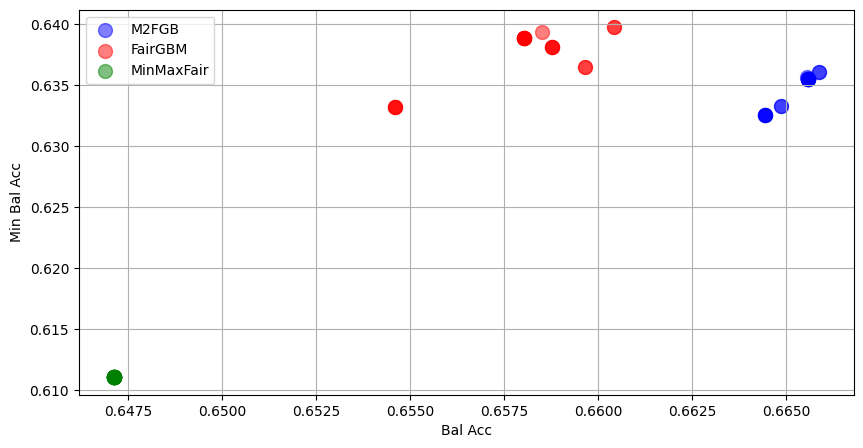

In [74]:
n_groups = 2
dataset_name = "compas"


model_name = "M2FGB_grad"
path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
results_m2fgb = get_result_dataframe(dataset_name, model_name, path)

model_name = "FairGBMClassifier"
path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
results_fairgbm = get_result_dataframe(dataset_name, model_name, path)

model_name = "MinMaxFair"
path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
results_mmfair = get_result_dataframe(dataset_name, model_name, path)


fig = plt.subplots(figsize = (10, 5))
#plt.subplot(1, 2, 1)
plt.scatter(
    results_m2fgb.bal_acc,
    results_m2fgb.min_bal_acc,
    c = "blue",
    s = 100,
    vmin = -0.5,
    alpha = 0.5,
    label = "M2FGB"
)

plt.legend()
plt.xlabel("Bal Acc")
plt.ylabel("Min Bal Acc")
plt.grid()

#plt.subplot(1, 2, 2)
plt.scatter(
    results_fairgbm.bal_acc,
    results_fairgbm.min_bal_acc,
    c = "red",
    s = 100,
    vmin = -0.5,
    alpha = 0.5,
    label = "FairGBM",
)


plt.scatter(
    results_mmfair.bal_acc,
    results_mmfair.min_bal_acc,
    c = "green",
    s = 100,
    vmin = -0.5,
    alpha = 0.5,
    label = "MinMaxFair",
)

plt.legend()
plt.xlabel("Bal Acc")
plt.ylabel("Min Bal Acc")
plt.grid(True)
plt.show()


10
10
10


/tmp/ipykernel_688/218385311.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(
/tmp/ipykernel_688/218385311.py:36: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(
/tmp/ipykernel_688/218385311.py:47: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(


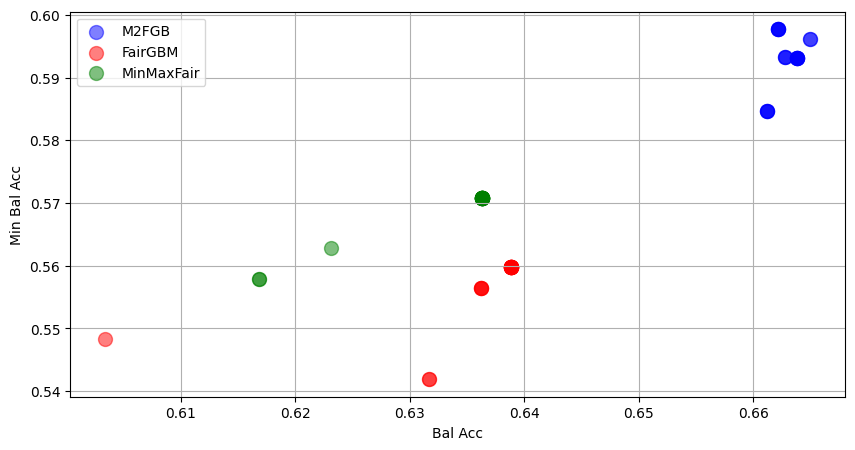

In [77]:
n_groups = 4
dataset_name = "compas"


model_name = "M2FGB_grad"
path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
results_m2fgb = get_result_dataframe(dataset_name, model_name, path)

model_name = "FairGBMClassifier"
path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
results_fairgbm = get_result_dataframe(dataset_name, model_name, path)

model_name = "MinMaxFair"
path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
results_mmfair = get_result_dataframe(dataset_name, model_name, path)


fig = plt.subplots(figsize = (10, 5))
#plt.subplot(1, 2, 1)
plt.scatter(
    results_m2fgb.bal_acc,
    results_m2fgb.min_bal_acc,
    c = "blue",
    s = 100,
    vmin = -0.5,
    alpha = 0.5,
    label = "M2FGB"
)

plt.legend()
plt.xlabel("Bal Acc")
plt.ylabel("Min Bal Acc")
plt.grid()

#plt.subplot(1, 2, 2)
plt.scatter(
    results_fairgbm.bal_acc,
    results_fairgbm.min_bal_acc,
    c = "red",
    s = 100,
    vmin = -0.5,
    alpha = 0.5,
    label = "FairGBM",
)


plt.scatter(
    results_mmfair.bal_acc,
    results_mmfair.min_bal_acc,
    c = "green",
    s = 100,
    vmin = -0.5,
    alpha = 0.5,
    label = "MinMaxFair",
)

plt.legend()
plt.xlabel("Bal Acc")
plt.ylabel("Min Bal Acc")
plt.grid(True)
plt.show()


10
10
10


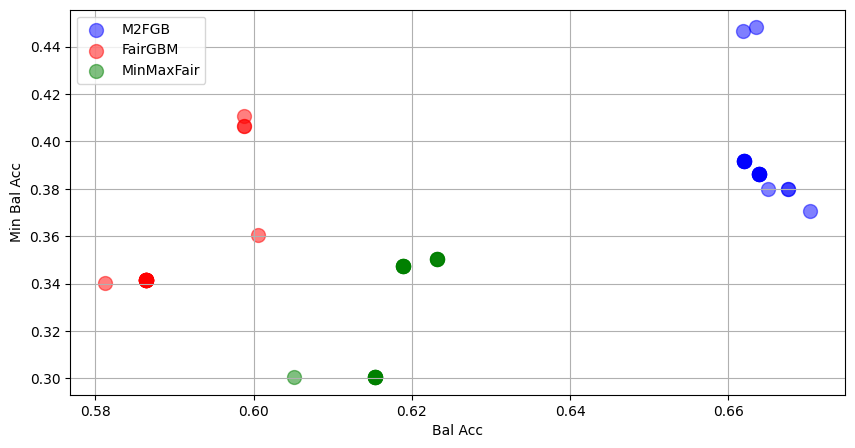

In [81]:
n_groups = 8
dataset_name = "compas"


model_name = "M2FGB_grad"
path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
results_m2fgb = get_result_dataframe(dataset_name, model_name, path)

model_name = "FairGBMClassifier"
path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
results_fairgbm = get_result_dataframe(dataset_name, model_name, path)

model_name = "MinMaxFair"
path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
results_mmfair = get_result_dataframe(dataset_name, model_name, path)


fig = plt.subplots(figsize = (10, 5))
#plt.subplot(1, 2, 1)
plt.scatter(
    results_m2fgb.bal_acc,
    results_m2fgb.min_bal_acc,
    c = "blue",
    s = 100,
    alpha = 0.5,
    label = "M2FGB"
)

plt.legend()
plt.xlabel("Bal Acc")
plt.ylabel("Min Bal Acc")
plt.grid()

#plt.subplot(1, 2, 2)
plt.scatter(
    results_fairgbm.bal_acc,
    results_fairgbm.min_bal_acc,
    c = "red",
    s = 100,
    alpha = 0.5,
    label = "FairGBM",
)


plt.scatter(
    results_mmfair.bal_acc,
    results_mmfair.min_bal_acc,
    c = "green",
    s = 100,
    alpha = 0.5,
    label = "MinMaxFair",
)

plt.legend()
plt.xlabel("Bal Acc")
plt.ylabel("Min Bal Acc")
plt.grid(True)
plt.show()
